In [70]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터 읽어보기

train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [71]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words= 30185):
    
    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(30185-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    #텍스트 스트링을 사전 인덱스 스트링으로 전환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [72]:
index_to_word = {index: word for word, index in word_to_index.items()}

In [73]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [74]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = len(word_to_index)  
word_vector_dim = 38    # 위 그림과 같이 4차원의 워드벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

raw_inputs = np.array(get_encoded_sentences(train_data, word_to_index))
raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post',
                                                       maxlen=41)
output = embedding(raw_inputs)


print(raw_inputs)
print(len(word_to_index))
print(output)

[[1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0]]
30185
tf.Tensor(
[[[-0.03515774 -0.00217348 -0.00859146 ... -0.02924401 -0.02773402
   -0.02899982]
  [ 0.01803769  0.0217036   0.03558679 ... -0.01608223  0.03170339
   -0.04390439]
  [-0.03599469  0.0265079   0.01385455 ...  0.03223534  0.04385899
    0.01114849]
  ...
  [-0.03599469  0.0265079   0.01385455 ...  0.03223534  0.04385899
    0.01114849]
  [-0.03599469  0.0265079   0.01385455 ...  0.03223534  0.04385899
    0.01114849]
  [-0.03599469  0.0265079   0.01385455 ...  0.03223534  0.04385899
    0.01114849]]

 [[-0.03515774 -0.00217348 -0.00859146 ... -0.02924401 -0.02773402
   -0.02899982]
  [ 0.01803769  0.0217036   0.03558679 ... -0.01608223  0.03170339
   -0.04390439]
  [-0.03599469  0.0265079   0.01385455 ...  0.032

In [75]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=41)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=41)

print(X_train.shape)

(146182, 41)


In [76]:
vocab_size = 30185    # 어휘 사전의 크기입니다 
word_vector_dim = 38  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 38)          1147030   
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 1504      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 1,148,615
Trainable params: 1,148,615
Non-trainable params: 0
_________________________________________________________________


In [77]:
# validation set 
x_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(x_val.shape)

(116182, 41)
(116182,)
(30000, 41)


In [78]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
227/227 [==============================] - 4s 20ms/step - loss: 0.5995 - accuracy: 0.6375 - val_loss: 0.3942 - val_accuracy: 0.8380
Epoch 2/20
227/227 [==============================] - 4s 19ms/step - loss: 0.3505 - accuracy: 0.8554 - val_loss: 0.3490 - val_accuracy: 0.8506
Epoch 3/20
227/227 [==============================] - 4s 18ms/step - loss: 0.2933 - accuracy: 0.8834 - val_loss: 0.3567 - val_accuracy: 0.8471
Epoch 4/20
227/227 [==============================] - 4s 19ms/step - loss: 0.2666 - accuracy: 0.8967 - val_loss: 0.3714 - val_accuracy: 0.8453
Epoch 5/20
227/227 [==============================] - 4s 18ms/step - loss: 0.2489 - accuracy: 0.9045 - val_loss: 0.3869 - val_accuracy: 0.8427
Epoch 6/20
227/227 [==============================] - 4s 18ms/step - loss: 0.2338 - accuracy: 0.9107 - val_loss: 0.3997 - val_accuracy: 0.8374
Epoch 7/20
227/227 [==============================] - 4s 17ms/step - loss: 0.2198 - accuracy: 0.9183 - val_loss: 0.3994 - val_accuracy: 0.8404

In [79]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6011 - accuracy: 0.8213
[0.601128339767456, 0.8213072419166565]


In [80]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(30185, 38)


In [81]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

# 한글 Word2Vec 사용하기

In [82]:
from gensim.models import KeyedVectors
import gensim
word2vec = gensim.models.Word2Vec.load('~/aiffel/sentiment_classification/ko/ko.bin')

result = word2vec.wv.most_similar("강아지")
print(result)

[('고양이', 0.7290453314781189), ('거위', 0.7185634970664978), ('토끼', 0.7056223750114441), ('멧돼지', 0.6950401067733765), ('엄마', 0.693433403968811), ('난쟁이', 0.6806551218032837), ('한마리', 0.6770296096801758), ('아가씨', 0.675035297870636), ('아빠', 0.6729634404182434), ('목걸이', 0.6512461304664612)]


In [83]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("영화")

/home/aiffel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.7052942514419556),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571459174156189),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428800821304321),
 ('애니메이션', 0.6425570249557495)]

In [84]:
vocab_size = 30185    # 어휘 사전의 크기입니다(30,185개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [85]:
# 첫번째 모델 : 1-D CNN 사용


from keras.initializers import Constant

vocab_size = 30185   # 어휘 사전의 크기입니다(30,185개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=41, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(64, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(64, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 41, 200)           6037000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 64)            89664     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 64)             28736     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 520       
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

# 두번째 모델: GlobalMaxPooling1D 사용

vocab_size = 10000  # 어휘 사전의 크기입니다(10000개의 단어)
word_vector_dim = 4  

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

# 세번째 모델: LSTM 사용

from keras.initializers import Constant

vocab_size = 30185 #어휘 사전의 크기입니다(30185개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer = Constant(embedding_matrix),
                                 input_length = 41, trainable = True))
model.add(keras.layers.LSTM(64, return_sequences = True))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [86]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs= 10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
227/227 [==============================] - 17s 74ms/step - loss: 0.5388 - accuracy: 0.7135 - val_loss: 0.4261 - val_accuracy: 0.8020
Epoch 2/10
227/227 [==============================] - 16s 72ms/step - loss: 0.3722 - accuracy: 0.8378 - val_loss: 0.3713 - val_accuracy: 0.8361
Epoch 3/10
227/227 [==============================] - 17s 75ms/step - loss: 0.3004 - accuracy: 0.8754 - val_loss: 0.3532 - val_accuracy: 0.8467
Epoch 4/10
227/227 [==============================] - 18s 78ms/step - loss: 0.2487 - accuracy: 0.9022 - val_loss: 0.3611 - val_accuracy: 0.8489
Epoch 5/10
227/227 [==============================] - 17s 74ms/step - loss: 0.2062 - accuracy: 0.9219 - val_loss: 0.3847 - val_accuracy: 0.8492
Epoch 6/10
227/227 [==============================] - 17s 75ms/step - loss: 0.1707 - accuracy: 0.9383 - val_loss: 0.4225 - val_accuracy: 0.8401
Epoch 7/10
227/227 [==============================] - 17s 73ms/step - loss: 0.1352 - accuracy: 0.9535 - val_loss: 0.4538 - val_accuracy:

In [87]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.5984 - accuracy: 0.8287
[0.5984088778495789, 0.828671395778656]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


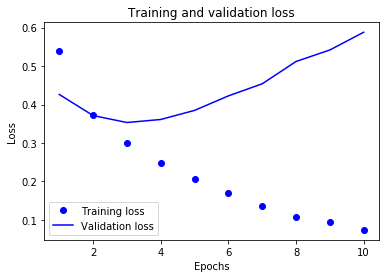

In [88]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

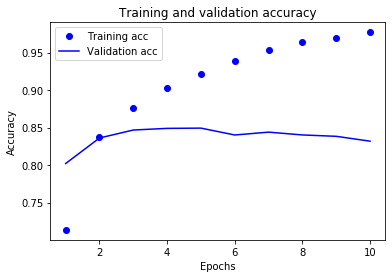

In [89]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

epoch 수를 20 으로 하면 overfitting 이 일어나는것을 그래프를 통해 알수 있었습니다. Validation set 의 accuracy 또한 2회 이후로는 크게 증가하진않고 오히려 loss 값만 더 늘어나는것을 보아 아무래도 모델과 잘 맞지않다고 생각하여 다른모델도 돌려보았으나 큰 차이는 없었습니다. 한글 벡터를 사용해서 2프로정도 더 성능이 좋아졌으나, 90프로 이상 정확도를 맞추기에는 어려웠습니다.